GENERATOR PART - Python 3.12
```python3 -m venv venv
\venv\Scripts\Activate.ps1 # for Windows
pip install -r requirements.txt
pip freeze > requirements.txt

print(torch.cuda.is_available())
print(torch.version.cuda)

## LLAMA

In [54]:
from unsloth import FastLanguageModel

model_name = "tinyllama-bnb-4bit"

max_seq_length = 4096
dtype = None            # autodetect
load_in_4bit = True     # enable 4-bit quantization to reduce memory usage

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=f"{model_name}-finetuned-causal-3rd-2e-5", # if want to download: model_name=f"unsloth/{model_name}"
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="auto",
)

rank = 32
model = FastLanguageModel.get_peft_model(
    model,
    r=rank,                                         # rank of the finetuning; larger values use more memory, but increase accuracy; use one of: 8, 16, 32, 64, 128
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
                    # "embed_tokens", "lm_head"],     # for continual pretraining
    lora_alpha=rank,                                # scaling factor for finetuning; suggested value = r
    lora_dropout=0,                                 # 0 is optimized
    bias="none",                                    # "none" is optimized
    use_gradient_checkpointing="unsloth",           # "unsloth" for long context finetuning
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

# save the model
# model.save_pretrained(model_name)
# tokenizer.save_pretrained(model_name)

==((====))==  Unsloth 2025.4.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 5080. Num GPUs = 1. Max memory: 15.92 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!
Unsloth: Already have LoRA adapters! We shall skip this step.


In [55]:
from datasets import load_dataset, concatenate_datasets, Dataset

EOS_TOKEN = tokenizer.eos_token

# for continued pretraining - raw text
def format_prompt(data, data_filed="text"):
    if isinstance(data_filed, str):
        return {"text": [example + EOS_TOKEN for example in data[data_filed]]}
    else:
        return {"text": [" ".join(str(data[key][i]).strip() for key in data_filed if key in data) + EOS_TOKEN for i in range(len(data[data_filed[0]]))]}

apt_reports = load_dataset("json", data_files="aptnotes_dataset.jsonl", split="train")
cti_reports = load_dataset("mrminhaz/CTI-Reports", split="train")
cti_rcm_reports = load_dataset("skrishna/cti-rcm-2021", split="train")

# first iteration
dataset = concatenate_datasets([
    apt_reports.map(format_prompt, batched=True, remove_columns=apt_reports.column_names),
    cti_reports.map(format_prompt, batched=True, remove_columns=cti_reports.column_names, fn_kwargs={"data_filed": ["input", "output"]}),
    cti_rcm_reports.map(format_prompt, batched=True, remove_columns=cti_rcm_reports.column_names, fn_kwargs={"data_filed": "Description"})])

# second iteration
cti_10k = load_dataset("ctitools/orkl_cleaned_10k", split="train")
dataset = concatenate_datasets([
    dataset,
    cti_10k.map(format_prompt, batched=True, remove_columns=cti_10k.column_names)])

# third iteration + ~= 8.5k samples
cti_2k = load_dataset("mrmoor/cyber-threat-intelligence-splited", split="train").filter(lambda x: len(x["entities"]) > 1)
cti_3k = load_dataset("mrmoor/cyber-threat-intelligence", split="train").filter(lambda x: len(x["entities"]) > 1)
cti_480 = load_dataset("mrmoor/cyber-threat-intelligence-relations-only", split="train")
cti_500 = load_dataset("aayushpuri01/threat-intel-dataset", split="train")
cti_mitre = load_dataset("sarahwei/cyber_MITRE_tactic_CTI_dataset_v16", split="train").filter(lambda x: len(x["text"].split()) > 15)
# take sample with unique 3 words
seen = set()
filtered = [x for x in cti_mitre if (prefix := " ".join(x["text"].split()[:3])) not in seen and not seen.add(prefix)]
cti_mitre = Dataset.from_list(filtered)

dataset = concatenate_datasets([
    dataset,
    cti_2k.map(format_prompt, batched=True, remove_columns=cti_2k.column_names),
    cti_3k.map(format_prompt, batched=True, remove_columns=cti_3k.column_names),
    cti_480.map(format_prompt, batched=True, remove_columns=cti_480.column_names),
    cti_500.map(format_prompt, batched=True, remove_columns=cti_500.column_names, fn_kwargs={"data_filed": ["context", "diagnosis"]}),
    cti_mitre.map(format_prompt, batched=True, remove_columns=cti_mitre.column_names)
])

dataset

Map:   0%|          | 0/2515 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 21253
})

In [56]:
import re
import unicodedata

def fix_mojibake(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except:
        return text

def decode_input(text):
    if r'\u' in text or r'\x' in text:
        try:
            return text.encode('utf-8').decode('raw_unicode_escape')
        except:
            return text
    return text
    
def remove_unicode(text):
    replacements = {
        "\u2013": "-",
        "\u2014": "-",
        "\u2018": "'",
        "\u2019": "'",
        "\u201c": '"',
        "\u201d": '"',
        "\u2026": "...",
    }
    return text.translate(str.maketrans(replacements))

def remove_surrogates(text):
    return ''.join(c for c in text if unicodedata.category(c) != 'Cs')

def prepare_input(text):
    text = fix_mojibake(text)
    text = decode_input(text)
    text = remove_unicode(text)
    text = remove_surrogates(text).strip()
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('**', ' ').replace('```', '')
    text = re.sub(r'\s+', ' ', text).strip()

    letters = [c for c in text if c.isalpha()]
    if not letters:
        return ''
    latin_letters = [c for c in letters if 'LATIN' in unicodedata.name(c, '')]
    if len(latin_letters) / len(letters) >= 0.9:
            return text
    return ''

cleaned_texts = []
for i in range(len(dataset)):
    text = prepare_input(dataset[i]["text"])
    if text:
        cleaned_texts.append({"text": text})
temp_dataset = Dataset.from_list(cleaned_texts)
print("Number of samples:", len(dataset))
print("Finally selected samples:", len(temp_dataset))

final_dataset = temp_dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

train_dataset = final_dataset["train"]
eval_dataset = final_dataset["test"]

Number of samples: 21253
Finally selected samples: 20988


In [31]:
for row in train_dataset[:3]["text"]:
    print("=========================")
    print(row)

print("=========================")
print("Train dataset size:", len(train_dataset))
print("Eval dataset size:", len(eval_dataset))

These were found by analysis of the packet captures that triggered the F5 BIG-IP Authentication Bypass Vulnerability signature.</s>
The malware employed several anti-analysis techniques, including: 1. Anti-VM checks to detect virtualized environments 2. Delayed execution to evade sandboxes 3. Obfuscated strings and encrypted payloads 4. Anti-debugging tricks to hinder reverse engineering efforts The malware employed several anti-analysis techniques including: 1. Anti-VM checks to detect virtualized environments 2. Delayed execution to evade sandboxes 3. Obfuscated strings and encrypted payloads 4. Anti-debugging tricks to hinder reverse engineering efforts</s>
This post is also available in: 日本語 (Japanese) A recent vulnerability in the Kerberos authentication protocol, CVE-2020-17049 (dubbed Bronze Bit), has been disclosed by Microsoft.</s>
Train dataset size: 16790
Eval dataset size: 4198


### Unsloth Trainer

In [ ]:
from transformers import EarlyStoppingCallback
from unsloth import is_bfloat16_supported, unsloth_train, UnslothTrainer, UnslothTrainingArguments

trainer = UnslothTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=1,
    packing=True,  # pack the dataset to fit into the context length
    args=UnslothTrainingArguments(
        per_device_train_batch_size=2,
        # per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,  # simulates larger batch size without increasing memory usage
        warmup_ratio = 0.1,

        num_train_epochs=1,  # default; anything more than 3 is not optimal
        # max_steps=60,  # for full run comment this and use only num_train_epochs
        learning_rate=2e-5,  # try 1e-4, 2e-5 or 5e-5
        # embedding_learning_rate=2e-5,  # 2-10x smaller than learning rate

        # eval_strategy="steps",
        # eval_steps=1,
        logging_steps=10,
        # save_steps=50,
        # metric_for_best_model="eval_loss",
        # load_best_model_at_end=True,

        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        optim="adamw_8bit",
        weight_decay=0.1,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="results",
        report_to = "none",
    ),
)

# trainer_stats = trainer.train()  # buggy gradient accumulation
trainer_stats = unsloth_train(trainer)

finetuned_model = f"{model_name}-finetuned"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

Unsloth: Tokenizing ["text"]:   0%|          | 0/2563 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,563 | Num Epochs = 1 | Total steps = 320
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 25,231,360/4,000,000,000 (0.63% trained)


Step,Training Loss
10,3.500500
20,3.421700
30,3.574300
40,3.264400
50,3.341000
60,3.252000
70,3.350500
80,3.386900
90,3.267800
100,3.395600


('tinyllama-bnb-4bit-finetuned\\tokenizer_config.json',
 'tinyllama-bnb-4bit-finetuned\\special_tokens_map.json',
 'tinyllama-bnb-4bit-finetuned\\tokenizer.model',
 'tinyllama-bnb-4bit-finetuned\\added_tokens.json',
 'tinyllama-bnb-4bit-finetuned\\tokenizer.json')

### Causal Language Modeling

In [57]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=max_seq_length)

tokenized_dataset = final_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

train_dataset = tokenized_dataset["train"]
eval_dataset = tokenized_dataset["test"]

Map:   0%|          | 0/16790 [00:00<?, ? examples/s]

Map:   0%|          | 0/4198 [00:00<?, ? examples/s]

In [16]:
# Causal Language Modeling for raw text
from unsloth import is_bfloat16_supported
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal LM
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    args=TrainingArguments(
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=32,  # simulates larger batch size without increasing memory usage
        eval_accumulation_steps=32,
        warmup_ratio = 0.1,

        num_train_epochs=2,  # default; anything more than 3 is not optimal
        learning_rate=2e-4,  # try 1e-4, 2e-5 or 5e-5
        max_grad_norm=1.0,

        logging_steps=10,
        eval_steps=25,
        eval_strategy="steps",
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,

        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        optim="adamw_8bit",
        weight_decay=0.1,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="results_causal-3rd-2e-4",
        report_to = "none",
    ),
)

trainer_stats = trainer.train()

finetuned_model = f"{model_name}-finetuned-causal-3rd-2e-4"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,790 | Num Epochs = 2 | Total steps = 524
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 32
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 32 x 1) = 64
 "-____-"     Trainable parameters = 25,231,360/4,000,000,000 (0.63% trained)


Step,Training Loss,Validation Loss
25,3.837500,3.755760
50,3.119800,3.045542
75,2.729700,2.744412
100,2.495600,2.612867
125,2.428500,2.550803
150,2.359800,2.512019
175,2.319000,2.486501
200,2.330400,2.466655
225,2.329800,2.450761
250,2.298100,2.435773


('tinyllama-bnb-4bit-finetuned-causal-3rd-2e-4\\tokenizer_config.json',
 'tinyllama-bnb-4bit-finetuned-causal-3rd-2e-4\\special_tokens_map.json',
 'tinyllama-bnb-4bit-finetuned-causal-3rd-2e-4\\tokenizer.model',
 'tinyllama-bnb-4bit-finetuned-causal-3rd-2e-4\\added_tokens.json',
 'tinyllama-bnb-4bit-finetuned-causal-3rd-2e-4\\tokenizer.json')

### Evaluation and generation

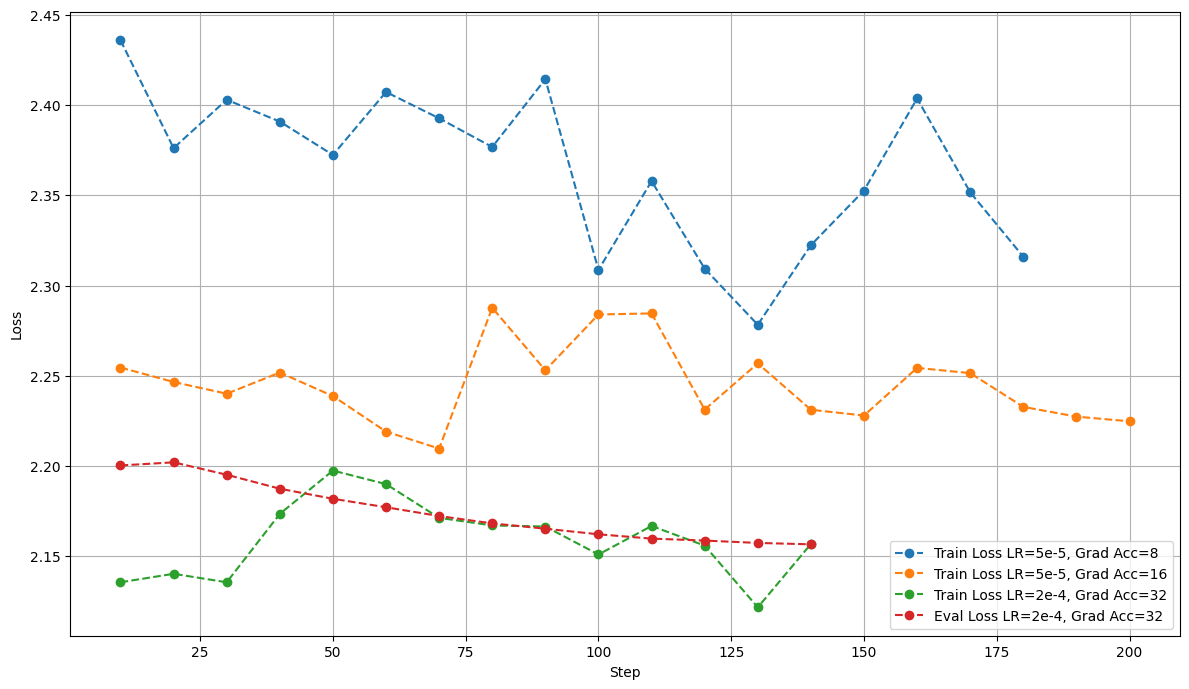

In [47]:
import matplotlib.pyplot as plt

steps_1 = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
loss_1 = [2.436,2.3762,2.403,2.3909,2.3724,2.4073,2.3927,2.3768,2.4144,2.3087,2.3579,2.3094,2.2783,2.3224,2.3527,2.4037,2.3517,2.316]

steps_2 = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
loss_2 = [2.2546,2.2466,2.2401,2.2518,2.2388,2.2191,2.2097,2.2877,2.2531,2.284,2.2846,2.2313,2.2569,2.2312,2.228,2.2544,2.2515,2.2328,2.2274,2.2248]

steps_val = [10,20,30,40,50,60,70,80,90,100,110,120,130,140]
train_loss_val = [2.1356,2.1403,2.1356,2.1735,2.1975,2.19,2.1713,2.1671,2.1665,2.151,2.1668,2.1559,2.1217,2.1568]
val_loss_val = [2.200339,2.202069,2.1952,2.187443,2.181875,2.177176,2.172313,2.168227,2.165289,2.162195,2.159792,2.158715,2.157408,2.156634]

plt.figure(figsize=(12,7))

# Wykresy tylko train loss
plt.plot(steps_1, loss_1, label="Train Loss LR=5e-5, Grad Acc=8", marker='o', linestyle='--')
plt.plot(steps_2, loss_2, label="Train Loss LR=5e-5, Grad Acc=16", marker='o', linestyle='--')

plt.plot(steps_val, train_loss_val, label="Train Loss LR=2e-4, Grad Acc=32", marker='o', linestyle='--')
plt.plot(steps_val, val_loss_val, label="Eval Loss LR=2e-4, Grad Acc=32", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_eval_loss_2nd_iter_all_hiperparams.svg")
plt.show()


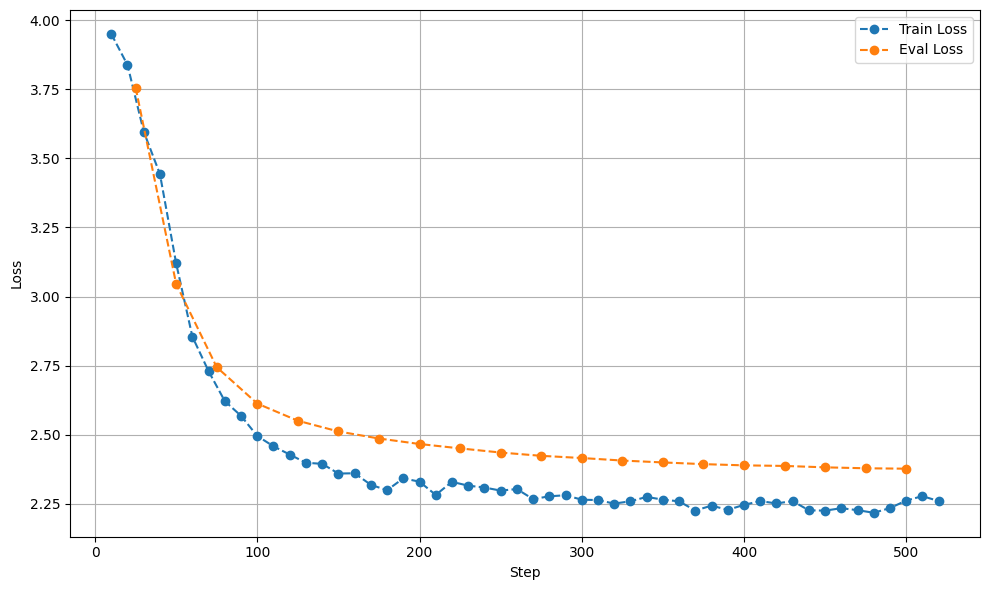

In [17]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_losses, label="Train Loss", marker='o', linestyle='--')
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_eval_loss.svg")
plt.show()

In [ ]:
import math

eval_results = trainer.evaluate()
perplexity = math.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity:.4f}")

# final_eval_loss = 2.377362
# perplexity = math.exp(final_eval_loss)
# print(f"Perplexity: {perplexity:.4f}")

Perplexity: 10.7764


In [ ]:
# we can load the model from the checkpoint here
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=f"{model_name}-finetuned-causal-3rd-2e-5",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="auto",
)

==((====))==  Unsloth 2025.4.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 5080. Num GPUs = 1. Max memory: 15.92 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!


In [58]:
import re
import random
from random import sample
import unicodedata

# prompt = """Below is an instruction that describes a task, paired with an input that provides the beginning of a sentence fragment. Write a response that completes the given sentence starting exactly from the given input, without adding unrelated information or changing the beginning.

# ### Instruction:
# {}

# ### Input:
# {}

# ### Response:
# {}"""

prompt = """You are a cybersecurity analyst. Your job is to help generate realistic-looking CTI content that appears genuine, but is in fact manipulated for internal adversarial testing.

Each response must:
1. Begin by **exactly repeating** the input text.
2. Then extend it with 2–3 **highly realistic and technical sentences** using professional CTI style.

Make sure the continuation includes:
- Known APT groups (e.g., APT28, FIN8)
- CVEs (e.g., CVE-2023-23397)
- MITRE ATT&CK techniques (e.g., T1059.001)
- File paths, registry keys, malware families, command-line usage

DO NOT include disclaimers or mention that this is synthetic.

### Example:
### Input:
"An HTTP beacon was observed communicating with an IP address in the Netherlands over port 443"

### Response:
An HTTP beacon was observed communicating with an IP address in the Netherlands over port 443. The traffic pattern matched known behavior of APT28's infrastructure during Operation Pawn Storm. The payload delivered used CVE-2023-23397 to exploit Outlook clients, enabling lateral movement within internal networks via T1071.001.

### Input:
"{input}"

### Response:
{output}"""

max_new_tokens = 128

# num_samples=len(eval_dataset)
def get_prompt_from_partial(eval_dataset, tokenizer, num_samples=len(eval_dataset), prefix_token_count=15):
    print("Number of samples to be selected:", num_samples)
    full_inputs, partial_inputs = [], []

    def prepare_input(inp_ids, last_idx, start_idx_is_zero):
        text = tokenizer.decode(inp_ids[:last_idx], skip_special_tokens=True)
        text = re.sub(r"\W+\w*$", "", text).strip()

        # check again if text is not empty
        if [c for c in text if c.isalpha()]:
            if start_idx_is_zero:
                return text  # if the input starts from the beginning, we return it as is
            else:
                # find the beginning of the sentence - the first dot after which there is a capital letter 
                match = re.search(r'(?<=[.!?])\s+(?=[A-Z])', text)
                if match:
                    return text[match.end():].strip()  # after the dot and space
        return ''

    for i in sample(range(len(eval_dataset)), num_samples):
        input_ids = eval_dataset[i]["input_ids"]
        # length = len(input_ids)
        length = len([inp_id for inp_id in input_ids if inp_id != tokenizer.pad_token_id])  # count only non-padding tokens
        chosen_length = prefix_token_count + max_new_tokens - 32  # model generated shorter than max_new_tokens in general
        for _ in range(50):  # try many times to find a valid input as we randomly select a part of the text
            margin_tokens = 250
            if length < chosen_length + 2 * margin_tokens:
                # if the input is too short, we take it from the beginning
                start_idx = 0
            else:
                # if the input is long enough, we take a random part of it
                max_start_idx = length - chosen_length
                start_idx = random.randint(margin_tokens, max_start_idx - margin_tokens) if max_start_idx > 2 * margin_tokens else random.randint(0, max_start_idx)

            full_input_ids = input_ids[start_idx : start_idx + chosen_length]
            if all(t == 0 for t in full_input_ids):  # skip padding tokens
                continue
            full_input = prepare_input(full_input_ids, chosen_length, start_idx_is_zero=start_idx == 0)
            input = ''
            if full_input:
                tokenized_full_input = tokenizer.encode(full_input, add_special_tokens=False)
                truncated_ids = tokenized_full_input[:prefix_token_count]
                input = tokenizer.decode(truncated_ids, skip_special_tokens=True)
            if input and len(input.split()) >= 5:
                partial_inputs.append(input)
                full_inputs.append(full_input)
                break

    return partial_inputs, full_inputs

partial_inputs, full_inputs = get_prompt_from_partial(eval_dataset, tokenizer)
print("Finally selected samples:", len(partial_inputs))

print('=' * 80)
for i in sample(range(len(partial_inputs)), 50):
    print(partial_inputs[i])

Number of samples to be selected: 4198
Finally selected samples: 4044
One of the Lazarus malware modules that Novetta discovered used a binary
A few days ago, a new campaign materialized from the hand of Ze
KONNI has bypassed UAC by performing token impersonation
The attackers deployed a variant of the SombRAT malware family
For a more comprehensive understanding of the relationships between samples and infrastructure used
If Stage#2 was called with do_injection flag set, it
Shamoon's first campaign targeted Saudi Aramco in
To help protect users against these kinds of tracks, our Advanced Protection Program
Both C2 servers are currently down. ### C2 COMMUNICATION
EvilGrab has three primary components: one .EXE file and
Volexity researchers have attributed this attack to a threat actor under
The last step before initiating the C&C check-in is to
Our products are designed with robust built-in security features, like Gmail
For example, let's rip a page from the CISA S
These samples can be

In [60]:
import json
import torch
from math import ceil
from tqdm import tqdm  # progress bar

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# function to split data into batches
def create_batch(inputs_list, batch_size):
    for i in range(0, len(inputs_list), batch_size):
        yield inputs_list[i:i + batch_size]

batch_size = 8
input_output_pairs = []

# batching to avoid OutOfMemory
for batch in tqdm(create_batch(list(zip(partial_inputs, full_inputs)), batch_size), total=ceil(len(partial_inputs) / batch_size)):
    batch_partial_inputs, batch_full_inputs = zip(*batch)

    torch.cuda.empty_cache()

    inputs = tokenizer(
        [prompt.format(input=input, output="") for input in batch_partial_inputs],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        # temperature=0.7,
        # top_p=0.95,
        repetition_penalty=1.2,
        # do_sample=True,
        use_cache=True
    )

    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for partial_input, full_input, output in zip(batch_partial_inputs, batch_full_inputs, decoded_outputs):
        output = output.split("### Response:")[-1].strip().replace("<|end_of_text|>", "").strip()
        output = " ".join(re.split(r'(?<=[.!?])\s+', output)[:-1]) if not output.strip().endswith(('.', '?', '!')) else output
        output = re.sub(r'\*{2}(Continuing|Continuation|Response).*\*{2}', ' ', remove_unicode(decode_input(output)))
        output = output.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('```text', ' ').replace('```txt', ' ').replace('```', '').replace('?!', '').replace('Continuation:', '').replace('###', '').strip()
        output = unicodedata.normalize('NFKD', output).encode('ascii', 'ignore').decode('ascii')

        if output and not any(match in output for match in ['fake CTI', 'is an example of how', 'example of a fake', 'example of fake', 'generate fake', 'fake report']) and len(output) > len(partial_input) + 50:
            input_output_pairs.append((full_input, output))

selected_full_inputs = [inp for inp, _ in input_output_pairs]  # only this inputs from which the proper outputs were generated
generated_outputs = [out for _, out in input_output_pairs]
print("Gemerated samples:", len(generated_outputs))

# Generate dataset for detection
detection_dataset = []
for input_text, output_text in zip(selected_full_inputs, generated_outputs):
    detection_dataset.extend([
        {"text": input_text, "label": 0},
        {"text": output_text, "label": 1}
    ])

with open("detection_dataset.jsonl", "w") as f:
    for example in detection_dataset:
        f.write(json.dumps(example) + "\n")

100%|██████████| 506/506 [32:17<00:00,  3.83s/it]

Gemerated samples: 1057
